In [10]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import time

In [11]:
# Custom CartPole environment wrapper
class CartPoleEnv:
    def __init__(self):
        self.env = gym.make('CartPole-v1', render_mode="rgb_array")
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        
        # Define state and action limits
        self.x_threshold = 2.4
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.max_velocity = 10
        
    def reset(self):
        state, _ = self.env.reset()
        return state
    
    def step(self, action):
        next_state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        
        # Custom reward shaping
        x, x_dot, theta, theta_dot = next_state
        
        # Normalize state components
        x_norm = abs(x) / self.x_threshold
        theta_norm = abs(theta) / self.theta_threshold_radians
        
        # Additional reward for staying centered and upright
        centered_reward = 1.0 - x_norm
        upright_reward = 1.0 - theta_norm
        
        # Combine rewards
        shaped_reward = reward + 0.1 * centered_reward + 0.2 * upright_reward
        
        return next_state, shaped_reward, done, info
    
    def render(self):
        self.env.render()
    
    def close(self):
        self.env.close()

In [12]:
class RiskSensitiveNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(RiskSensitiveNetwork, self).__init__()
        # Smaller network with normalized initialization
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value = nn.Linear(64, 1)
        self.policy = nn.Linear(64, action_dim)
        
        # Initialize weights with smaller values
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=0.5)
                nn.init.constant_(m.bias, 0.0)
    
    def forward(self, x):
        # Add state normalization
        x = (x - x.mean()) / (x.std() + 1e-8)
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        value = self.value(x)
        
        # Use log_softmax for better numerical stability
        policy_logits = self.policy(x)
        return policy_logits, value

In [13]:
class RiskSensitiveAgent:
    def __init__(self, state_dim, action_dim, alpha=0.95, learning_rate=0.0003):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.network = RiskSensitiveNetwork(state_dim, action_dim).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=learning_rate, eps=1e-5)
        self.memory = deque(maxlen=10000)
        self.alpha = alpha  # CVaR risk level
        self.state_dim = state_dim
        self.action_dim = action_dim
        
    def get_action(self, state, explore=True):
        state = np.array(state, dtype=np.float32)
        if state.shape != (self.state_dim,):
            raise ValueError(f"Invalid state shape. Expected ({self.state_dim},), got {state.shape}")
        
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            policy_logits, _ = self.network(state)
            # Use softmax with temperature for exploration
            temperature = 1.0 if explore else 0.1
            policy = torch.softmax(policy_logits / temperature, dim=-1)
            
            # Add small epsilon to avoid zero probabilities
            policy = policy + 1e-8
            policy = policy / policy.sum()  # Renormalize
            
            if explore:
                try:
                    action = torch.multinomial(policy, 1).item()
                except RuntimeError:
                    print(f"Warning: Policy values: {policy}")
                    action = random.randint(0, self.action_dim - 1)
            else:
                action = torch.argmax(policy).item()
        
        return action
    
    def store_transition(self, state, action, reward, next_state, done):
        state = np.array(state, dtype=np.float32)
        next_state = np.array(next_state, dtype=np.float32)
        self.memory.append((state, action, reward, next_state, done))
    
    def compute_cvar_loss(self, returns):
        sorted_returns = torch.sort(returns)[0]
        threshold_idx = max(1, int((1 - self.alpha) * len(returns)))
        cvar = torch.mean(sorted_returns[:threshold_idx])
        return -cvar
    
    def train(self, batch_size=32, gamma=0.99):
        if len(self.memory) < batch_size:
            return 0, 0
        
        batch = random.sample(self.memory, batch_size)
        states = torch.FloatTensor([t[0] for t in batch]).to(self.device)
        actions = torch.LongTensor([t[1] for t in batch]).to(self.device)
        rewards = torch.FloatTensor([t[2] for t in batch]).to(self.device)
        next_states = torch.FloatTensor([t[3] for t in batch]).to(self.device)
        dones = torch.FloatTensor([t[4] for t in batch]).to(self.device)
        
        # Get current policy and value
        policy_logits, current_value = self.network(states)
        _, next_value = self.network(next_states)
        
        # Calculate policy probabilities
        policy = torch.softmax(policy_logits, dim=-1)
        
        # Calculate returns with CVaR
        returns = rewards + gamma * next_value.squeeze() * (1 - dones)
        advantage = returns - current_value.squeeze()
        
        # Policy loss with clipping
        policy_ratio = policy.gather(1, actions.unsqueeze(1)).squeeze()
        policy_loss = -(torch.log(policy_ratio + 1e-8) * advantage.detach())
        
        # Value loss with CVaR and clipping
        value_loss = self.compute_cvar_loss(returns)
        value_loss = torch.clamp(value_loss, -10, 10)
        
        # Total loss with gradient clipping
        total_loss = policy_loss.mean() + 0.5 * value_loss
        
        # Optimize
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=0.5)
        self.optimizer.step()
        
        return policy_loss.mean().item(), value_loss.item()

In [14]:
class Visualizer:
    def __init__(self):
        plt.ion()
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, figsize=(10, 8))
        self.reward_line = None
        self.loss_lines = None
        
    def update(self, episode_rewards, policy_losses, value_losses):
        self.ax1.clear()
        self.ax2.clear()
        
        # Plot rewards
        self.ax1.plot(episode_rewards, 'b-', label='Episode Reward')
        self.ax1.set_title('Training Progress')
        self.ax1.set_xlabel('Episode')
        self.ax1.set_ylabel('Reward')
        self.ax1.grid(True)
        self.ax1.legend()
        
        # Plot losses if available
        if policy_losses and value_losses:
            episodes = range(len(policy_losses))
            self.ax2.plot(episodes, policy_losses, 'r-', label='Policy Loss')
            self.ax2.plot(episodes, value_losses, 'g-', label='Value Loss')
            self.ax2.set_title('Training Losses')
            self.ax2.set_xlabel('Episode')
            self.ax2.set_ylabel('Loss')
            self.ax2.grid(True)
            self.ax2.legend()
        
        plt.tight_layout()
        plt.pause(0.01)

In [15]:
def train_risk_sensitive_cartpole(episodes=1000, render=False, render_interval=100):
    env = CartPoleEnv()
    agent = RiskSensitiveAgent(env.state_dim, env.action_dim)
    visualizer = Visualizer()
    
    best_reward = 0
    episode_rewards = []
    policy_losses = []
    value_losses = []
    
    try:
        for episode in range(episodes):
            state = env.reset()
            episode_reward = 0
            episode_policy_loss = 0
            episode_value_loss = 0
            steps = 0
            done = False
            
            while not done:
                if render and episode % render_interval == 0:
                    env.render()
                
                # Get action
                try:
                    action = agent.get_action(state)
                except ValueError as e:
                    print(f"Error getting action: {e}")
                    print(f"State shape: {np.array(state).shape}")
                    raise e
                
                next_state, reward, done, info = env.step(action)
                
                # Store transition
                agent.store_transition(state, action, reward, next_state, done)
                
                # Train agent
                p_loss, v_loss = agent.train()
                episode_policy_loss += p_loss
                episode_value_loss += v_loss
                
                state = next_state
                episode_reward += reward
                steps += 1
            
            # Store metrics
            episode_rewards.append(episode_reward)
            if steps > 0:
                policy_losses.append(episode_policy_loss / steps)
                value_losses.append(episode_value_loss / steps)
            
            # Update visualization
            if episode % 10 == 0:
                visualizer.update(episode_rewards, policy_losses, value_losses)
            
            # Print progress
            if episode % 100 == 0:
                avg_reward = np.mean(episode_rewards[-100:])
                print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
                
                if avg_reward > best_reward:
                    best_reward = avg_reward
                    torch.save(agent.network.state_dict(), 'best_model.pth')
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    
    finally:
        env.close()
        plt.ioff()
        plt.show()
    
    return episode_rewards, policy_losses, value_losses

In [16]:
def evaluate_agent(episodes=10, render=True):
    env = CartPoleEnv()
    agent = RiskSensitiveAgent(env.state_dim, env.action_dim)
    
    try:
        agent.network.load_state_dict(torch.load('best_model.pth'))
    except FileNotFoundError:
        print("No saved model found. Please train the agent first.")
        return
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        
        while not done:
            if render:
                env.render()
                time.sleep(0.02)
            
            action = agent.get_action(state, explore=False)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            episode_reward += reward
        
        print(f"Evaluation Episode {episode + 1}, Reward: {episode_reward}")
    
    env.close()

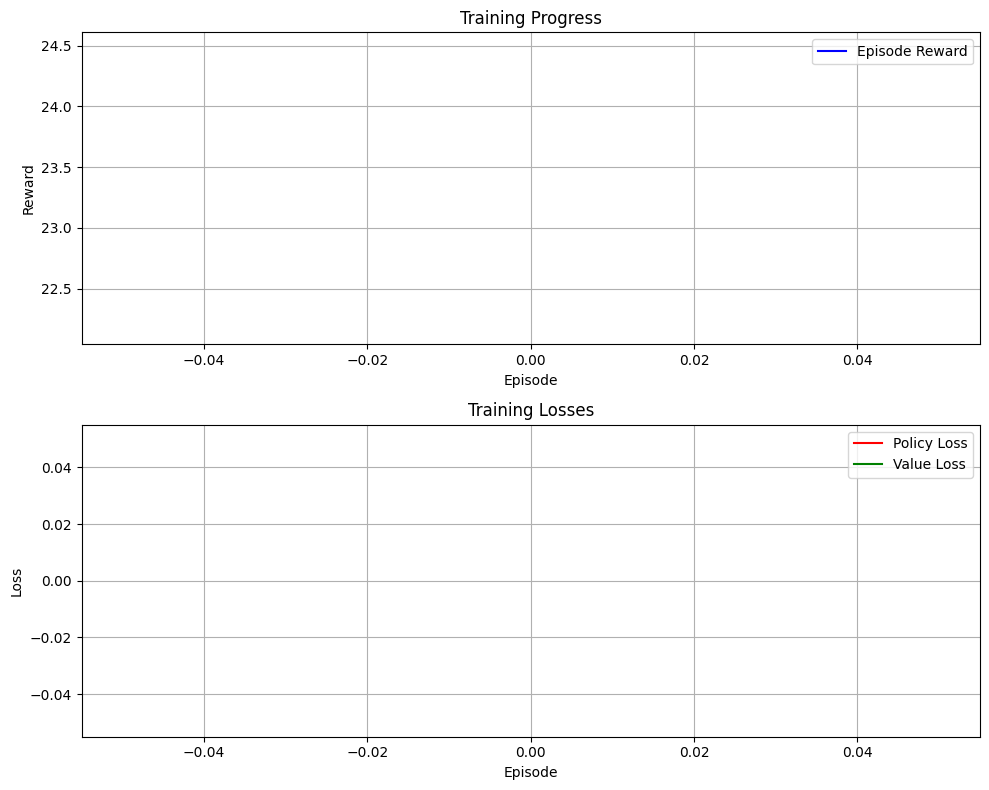

Episode 0, Average Reward: 23.33


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 100, Average Reward: 37.08


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 200, Average Reward: 34.57


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 300, Average Reward: 22.23


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 400, Average Reward: 43.38


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

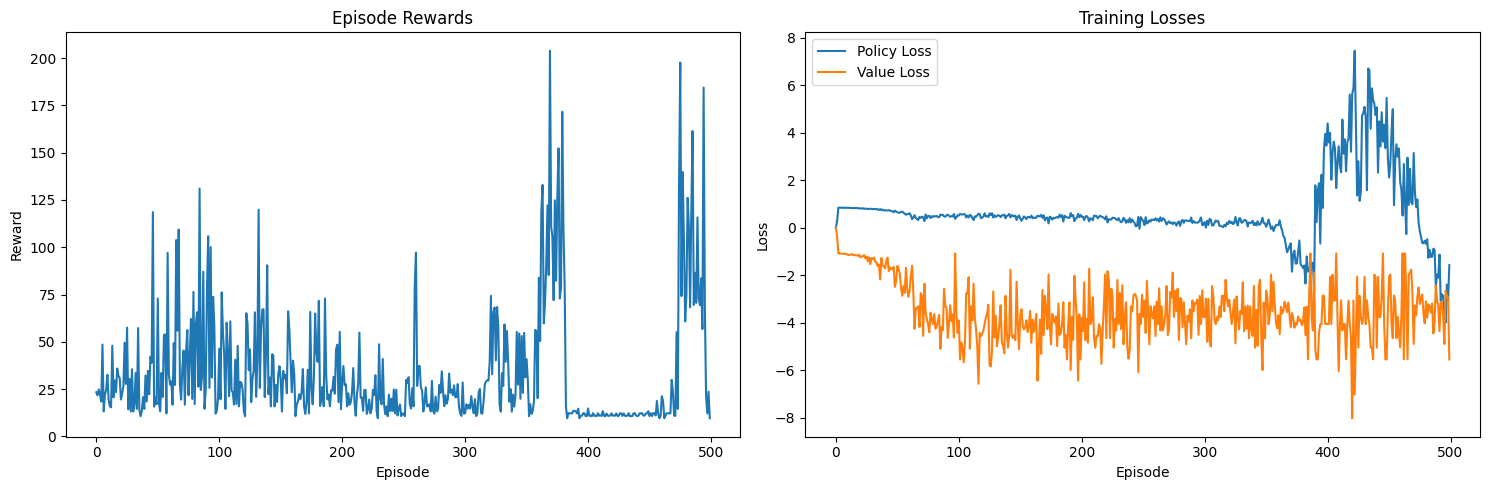


Evaluating trained agent...


C:\Users\00har\AppData\Local\Temp\ipykernel_2444\3917436753.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.network.load_state_dict(torch.load('best_model.pth'))


Evaluation Episode 1, Reward: 9.537453110008641
Evaluation Episode 2, Reward: 13.300319534178271
Evaluation Episode 3, Reward: 9.595132333287207
Evaluation Episode 4, Reward: 12.201865555985284
Evaluation Episode 5, Reward: 12.224476970859005
Evaluation Episode 6, Reward: 10.773129744281668
Evaluation Episode 7, Reward: 13.33680234019596
Evaluation Episode 8, Reward: 12.233565774682425
Evaluation Episode 9, Reward: 10.99495088211297
Evaluation Episode 10, Reward: 10.735141890567483


In [17]:

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Train the agent
rewards, policy_losses, value_losses = train_risk_sensitive_cartpole(episodes=500, render=True)

# Plot final results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(1, 2, 2)
plt.plot(policy_losses, label='Policy Loss')
plt.plot(value_losses, label='Value Loss')
plt.title('Training Losses')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the trained agent
print("\nEvaluating trained agent...")
evaluate_agent(episodes=10)